# Aula 5

---

**Saulo Martiello Mastelini**<br>
Candidato a Ph.D. pelo ICMC-USP<br>
Online Machine Learning

Página pessoal: [smastelini](https://smastelini.github.io/)</br>
e-mail: saulomastelini@gmail.com

---

## Sumário:

- Árvores de decisão
- Metodologia de avaliação: Leave-one-out
- Viés e variância: revisitados
- Interpretabilidade: modelos caixa branca e caixa preta
- Visualização de fronteiras de decisão

---

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

## 1. Árvores de decisão

- Geram modelos baseados em árvores de características

<img src="img/a5/dt.png" width="500px">
    <figcaption>Árvore de decisão. Fonte: <a href="https://www.javatpoint.com/machine-learning-decision-tree-classification-algorithm">Javatpoint</a></figcaption>
</img>

- Os atributos preditivos são particionados de forma hierárquica
- Divisão e conquista
- Geralmente utiliza uma estratégia gulosa (ou _greedy_)
    - A cada passo, seleciona a melhor solução localmente
- Os testes realizados nos atributos vão depender do tipo de dados
    - Divisão binária
    - Divisão n-ária
- Atributos numéricos ou categóricos
- As partições buscar deixar os dados mais puros/homogêneos a medida que são criadas as separações
    - Precisamos de medidas que indiquem a pureza dos dados

- Principais medidas de impureza para classificação:
    - Gini
    - Entropia
        $$\text{Entropy}(y) = -\sum_{c=1}^N P\left(\frac{y_c}{y}\right)\log_2\left(\frac{y_c}{y}\right)$$
- Principal medida de homogeneidade para regressão:
    - Variância
- Na prática:

In [2]:
def entropy(y):
    classes = np.unique(y)

    summ = 0.0
    for c in classes:
        prop = len(y[y == c]) / len(y)

        if prop > 0:
            summ += (prop * math.log2(prop))

    return -summ

In [3]:
X, y = load_iris(return_X_y=True, as_frame=True)

In [4]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64

In [5]:
entropy(y)

1.584962500721156

In [6]:
entropy(y[:50])

-0.0

In [7]:
entropy(y[:100])

1.0

In [8]:
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Vamos tentar uma partição dos dados

In [9]:
# Split binário

limiar1 = 6.3
sl1_x = X[X["sepal length (cm)"] <= limiar1]
sr1_x = X[X["sepal length (cm)"] > limiar1]

sl1_y = y[X["sepal length (cm)"] <= limiar1]
sr1_y = y[X["sepal length (cm)"] > limiar1]

In [10]:
len(sl1_x), len(sr1_x)

(108, 42)

In [11]:
entropy(sl1_y), entropy(sr1_y)

(1.486053069017246, 0.8296071030882031)

E se tentassemos uma outra estratégia?

In [12]:
limiar2 = 2.45

sl2_x = X[X["petal length (cm)"] <= limiar2]
sr2_x = X[X["petal length (cm)"] > limiar2]

sl2_y = y[X["petal length (cm)"] <= limiar2]
sr2_y = y[X["petal length (cm)"] > limiar2]

In [13]:
len(sl2_x), len(sr2_x)

(50, 100)

In [14]:
entropy(sl2_y), entropy(sr2_y)

(-0.0, 1.0)

- O que faz os valores serem diferentes?

In [15]:
sl2_y.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [16]:
sr2_y.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

- Information Gain (IG)
    - Estratégia sistemática para determinar o melhor split através da entropia
    
$$\text{IG}(y, y_L, y_R) = \text{Entropy}(y) - \frac{|y_L|}{|y|}\text{Entropy}(y_L) - \frac{|y_R|}{|y|}\text{Entropy}(y_LR)$$

In [17]:
def info_gain(y, yl, yr):
    wl = len(yl) / len(y)
    wr = len(yr) / len(y)

    return entropy(y) - wl * entropy(yl) - wr * entropy(yr)

In [18]:
info_gain(y, sl1_y, sr1_y)

0.28271430216404203

In [19]:
info_gain(y, sl2_y, sr2_y)

0.9182958340544894

A segunda opção gerou um maior valor de IG, logo, seria a melhor escolha dentre os dois.

## 2. Escolhendo o melhor atributo para particionar a árvore

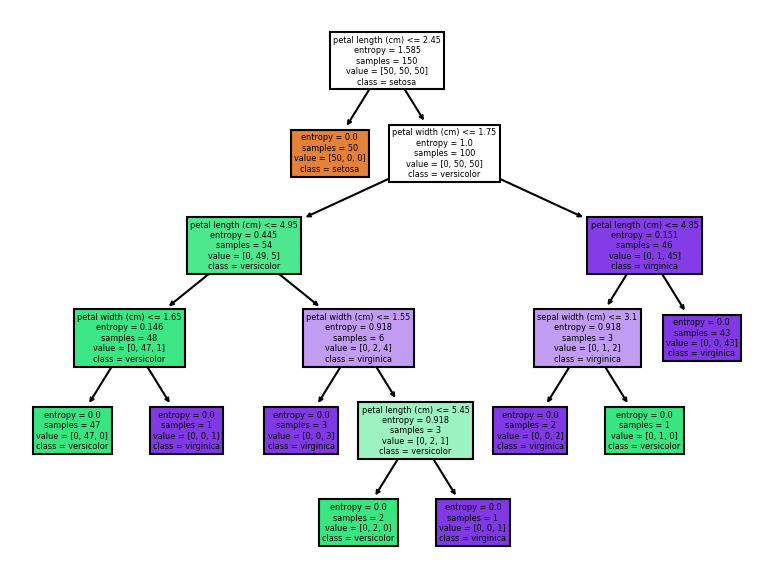

In [20]:
dt = DecisionTreeClassifier(criterion="entropy")
dt.fit(X, y)

plt.figure(dpi=150)
plot_tree(dt, feature_names=X.columns, class_names=["setosa", "versicolor", "virginica"], filled=True)
plt.show()

- Dado um atributo, temos que escolher o seu melhor split:

In [21]:
def best_split(x, y):
    uq = np.unique(np.sort(x))

    thresholds = []
    for i in range(1, len(uq)):
        thresholds.append(
            (uq[i-1] + uq[i]) / 2
        )

    info_gains = []

    for th in thresholds:
        yl = y[x <= th]
        yr = y[x > th]

        info_gains.append(info_gain(y, yl, yr))

    pos = np.argmax(info_gains)

    return thresholds[pos], info_gains[pos]

In [22]:
X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [23]:
best_split(X["sepal length (cm)"], y)

(5.55, 0.5572326878069267)

In [24]:
best_split(X["sepal width (cm)"], y)

(3.3499999999999996, 0.28312598916883136)

In [25]:
best_split(X["petal length (cm)"], y)

(2.45, 0.9182958340544894)

In [26]:
best_split(X["petal width (cm)"], y)

(0.8, 0.9182958340544894)

- Agora sabemos como encontrar o melhor split para um dado atributo
- Para completar: como aplicar o melhor split:

In [27]:
def split(X: pd.DataFrame, y: pd.Series):
    info_gains = []
    thresholds = []

    for col in X.columns:
        th, ig = best_split(X[col], y)

        thresholds.append(th)
        info_gains.append(ig)

    best = np.argmax(info_gains)
    split_feature = X.columns[best]
    split_thresh = thresholds[best]

    Xl = X[X[split_feature] <= split_thresh]
    Xr = X[X[split_feature] > split_thresh]

    yl = y[X[split_feature] <= split_thresh]
    yr = y[X[split_feature] > split_thresh]

    return Xl, yl, Xr, yr, split_feature, split_thresh

In [28]:
Xl, yl, Xr, yr, split_f, split_t = split(X, y)

In [29]:
len(Xl), len(Xr)

(50, 100)

In [30]:
np.unique(yl), np.unique(yr)

(array([0]), array([1, 2]))

In [31]:
split_f, split_t

('petal length (cm)', 2.45)

In [32]:
Xl, yl, Xr, yr, split_f, split_t = split(Xr, yr)

In [33]:
len(Xl), len(Xr)

(54, 46)

In [34]:
np.unique(yl), np.unique(yr)

(array([1, 2]), array([1, 2]))

In [35]:
split_f, split_t

('petal width (cm)', 1.75)

## 3. Quando parar: poda em árvores de decisão

Critérios de parada:

- Trivial: Todas as amostras em um nó pertencem à mesma classe

- Pré-poda:
    - Profundidade máxima atingida (hiper-parâmetro a ser definido)
    - Número máximo de folhas atingido
    - Um corte deve acarretar um ganho mínimo de informação, ou em outras palavras, diminuir a impureza dos dados em pelo menos um valor
- Pós-poda: após o crescimento da árvore, remove "galhos" que não trazem um ganho significativo de informação

[Documentação do sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

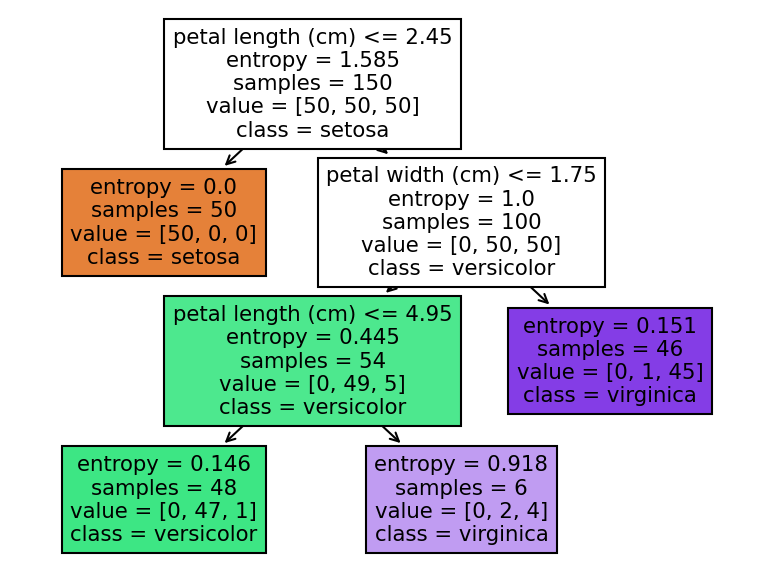

In [36]:
dt = DecisionTreeClassifier(criterion="entropy", ccp_alpha=0.05)
dt.fit(X, y)

plt.figure(dpi=150)
plot_tree(dt, feature_names=X.columns, class_names=["setosa", "versicolor", "virginica"], filled=True)
plt.show()

## 4. Viés e variância: fronteiras de decisão

- As árvores de decisão possuem um viés baixo e alta variância
    - São afetadas por pequenas mudanças nos dados de treinamento
    - Estratégias de poda podem ser utilizadas para reduzir esse efeito
- No entanto, tal sensibilidade aos dados de treinamento pode ser uma vantagem para **ensembles!**
    - Mais sobre isso nas próximas aulas!!!

In [37]:
# Adaptado de: https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py
def plot_decision_boundaries(X, y, model):
    from matplotlib import colormaps
    import matplotlib.markers as mmarkers
    def mscatter(x, y, ax=None, m=None, **kw):
        if not ax: ax=plt.gca()
        sc = ax.scatter(x,y,**kw)
        if (m is not None) and (len(m)==len(x)):
            paths = []
            for marker in m:
                if isinstance(marker, mmarkers.MarkerStyle):
                    marker_obj = marker
                else:
                    marker_obj = mmarkers.MarkerStyle(marker)
                path = marker_obj.get_path().transformed(
                            marker_obj.get_transform())
                paths.append(path)
            sc.set_paths(paths)
        return sc

    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")

    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Fits the model with the reduced data
    model.fit(reduced_data, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Right now it only works with binary tasks: expand both dictionaries or use cmap for multiclass tasks

    cmap = colormaps['brg']

    markers = {0: "o", 1: "^", 2: "s", 3: "D", 4: "+", 5: "*"}

    m = list(map(lambda i: markers[i], y))
    
    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    mscatter(x=X[:, 0], y=X[:, 1], c=y, m=m, cmap=cmap, alpha=1)
    
    plt.xlabel("x1",fontsize=15)
    plt.ylabel("x2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    return plt

DT


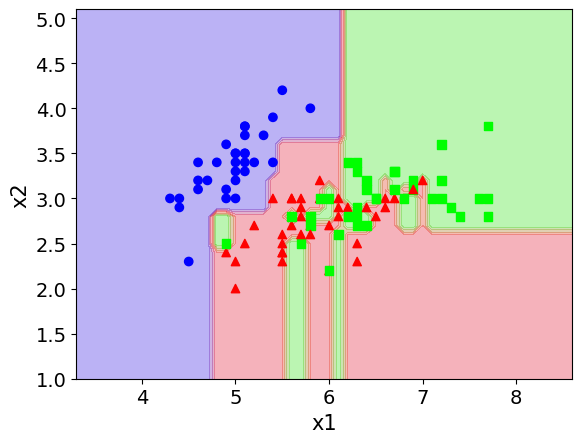

In [38]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # Holdout

X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

print("DT")
plot_decision_boundaries(X_train, y_train, DecisionTreeClassifier())
plt.show()

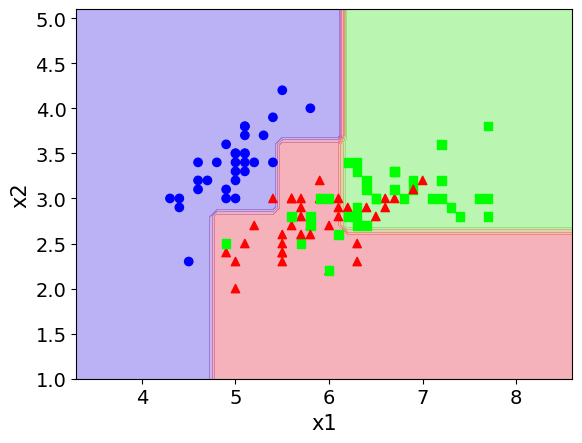

In [39]:
plot_decision_boundaries(X_train, y_train, DecisionTreeClassifier(max_depth=3))
plt.show()

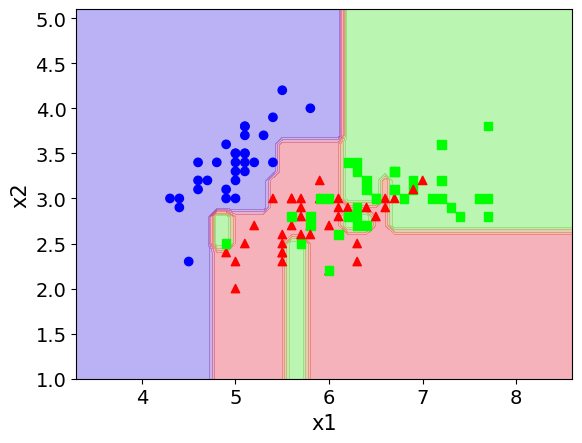

In [40]:
plot_decision_boundaries(X_train, y_train, DecisionTreeClassifier(ccp_alpha=0.0075))
plt.show()

Alta variância:

DT - seed 42


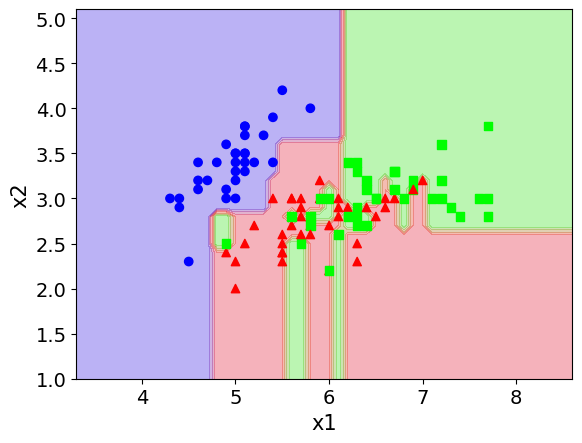

In [41]:
print("DT - seed 42")
plot_decision_boundaries(X_train, y_train, DecisionTreeClassifier())
plt.show()

DT - seed 43


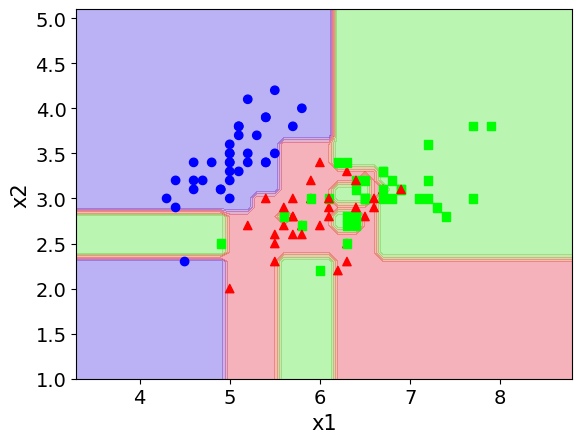

In [42]:
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=43)

print("DT - seed 43")
plot_decision_boundaries(X_train, y_train, DecisionTreeClassifier())
plt.show()

# TODO: Preencher durante a aula

- Vantagens DTs 
- Desvantagens DTs

## 5. Leave-one-out: Explorando os dados ao máximo


- Equivalente a fazer um k-fold Cross-Validation com `k == número de exemplos de treinamento`
- Para cada ponto, treina um modelo que aprende com todos os dados exceto o ponto em questão
- Teste com o ponto reservado no passo anterior

In [43]:
from sklearn.model_selection import KFold, LeaveOneOut, cross_validate
from sklearn.datasets import load_wine

In [44]:
X, y = load_wine(as_frame=True, return_X_y=True)

scores_loo = cross_validate(
    DecisionTreeClassifier(),
    X, y,
    scoring=["accuracy", "f1_macro"],
    cv=LeaveOneOut()
    
)

In [45]:
scores_loo = pd.DataFrame(scores_loo)
scores_loo.mean(axis=0)

fit_time         0.001865
score_time       0.001407
test_accuracy    0.893258
test_f1_macro    0.893258
dtype: float64

In [46]:
scores_loo.std(axis=0)

fit_time         0.001446
score_time       0.000601
test_accuracy    0.309655
test_f1_macro    0.309655
dtype: float64

In [47]:
scores_cv = cross_validate(
    DecisionTreeClassifier(),
    X, y,
    scoring=["accuracy", "f1_macro"],
    cv=KFold(n_splits=10, shuffle=True, random_state=10)
)

In [48]:
scores_cv = pd.DataFrame(scores_cv)
scores_cv.mean(axis=0)

fit_time         0.001764
score_time       0.001369
test_accuracy    0.882026
test_f1_macro    0.865719
dtype: float64

In [49]:
scores_cv.std(axis=0)

fit_time         0.000485
score_time       0.000227
test_accuracy    0.080969
test_f1_macro    0.093193
dtype: float64

LOO:

- Vantagens:
    - Medida mais realística do desempenho esperado do seu modelo
- Desvantagens:
    - Mais custosa de se calcular
    - Aumenta a variabilidade dos resultados obtidos

# Tarefa